In [1]:
import joblib

# Torch-related
import torch
from pytorch_model_summary import summary

# Custom defined
from config import fine_tuning
from libs.data import load_dataset, collate_fn, Dataset
from architecture.architecture import MaskedBlockAutoencoder
from architecture.shared_module import patchify, unpatchify

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
is_test_mode = False
is_new_rawdata = False
is_new_dataset = True
config = fine_tuning
device = torch.device("cuda")
# device = torch.device("cpu")

if is_new_dataset:
    train_dataset = load_dataset(is_test_mode, is_new_rawdata, config, mode="fine_tuning", verbose=True)
else:
    suffix = "_test" if is_test_mode else ""
    train_dataset = torch.load(f"src/fine_tuning_dataset{suffix}")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, config), pin_memory=True, num_workers=16, prefetch_factor=32)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, config))
for _ in train_dataloader:
    [print(key, val.shape) for key, val in _.items() if "scaler" not in key and "raw" not in key]
    break

100%|██████████| 29274/29274 [00:01<00:00, 19894.18it/s]
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


sales_encoder_input torch.Size([16, 302, 1])
sales_decoder_input torch.Size([16, 50, 1])
day_encoder_input torch.Size([16, 302])
day_decoder_input torch.Size([16, 50])
dow_encoder_input torch.Size([16, 302])
dow_decoder_input torch.Size([16, 50])
month_encoder_input torch.Size([16, 302])
month_decoder_input torch.Size([16, 50])
holiday_encoder_input torch.Size([16, 302])
holiday_decoder_input torch.Size([16, 50])
price_encoder_input torch.Size([16, 302, 1])
price_decoder_input torch.Size([16, 50, 1])
encoder_input_padding_mask torch.Size([16, 302])
decoder_input_padding_mask torch.Size([16, 50])
img_path torch.Size([16, 3, 224, 224])
detail_desc torch.Size([16, 54])
detail_desc_revert_padding_mask torch.Size([16, 55])
detail_desc_remain_idx torch.Size([16, 54])
detail_desc_masked_idx torch.Size([16, 0])
detail_desc_revert_idx torch.Size([16, 54])
information torch.Size([16, 34])
information_revert_padding_mask torch.Size([16, 35])
information_remain_idx torch.Size([16, 34])
information

Traceback (most recent call last):
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [3]:
path = "saved_model_epoch1_2024-05-19 23:06:13.856522"
label_encoder_dict = joblib.load("./src/label_encoder_dict.pkl")

mbae_encoder = MaskedBlockAutoencoder(config, label_encoder_dict)
mbae_encoder.load_state_dict(torch.load(path))
""

''

In [4]:
class Forecaster(torch.nn.Module):
    def __init__(self, config, encoder):
        super().__init__()
        self.config = config
        self.encoder = encoder
        self.forecaster = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(config.d_model["encoder"], config.nhead["encoder"], config.d_ff["encoder"], config.dropout, config.activation, batch_first=True), config.num_layers["encoder"])
        self.linear = torch.nn.Linear(self.config.d_model["encoder"], 1)

    def forward(self, data, device):
        encoder_input, decoder_input = {}, {}
        for key, val in data.items():
            if "encoder_input" in key:
                key = key.replace("_encoder_input", "")
                key = key.replace("encoder_input_", "")
                key = "temporal_padding_mask" if key == "padding_mask" else key
                encoder_input[key] = val
            elif "decoder_input" in key:
                key = key.replace("_decoder_input", "")
                key = key.replace("decoder_input_", "")
                key = "temporal_padding_mask" if key == "padding_mask" else key
                decoder_input[key] = val
            else:
                encoder_input[key] = val
                decoder_input[key] = val

        self.encoder.config.remain_rto["temporal"] = 1
        encoding_dict, data_dict, encoding_weight_dict, encoding_padding_mask_dict = self.encoder(encoder_input, device, "fine_tuning")
        self.encoder.config.remain_rto["temporal"] = 0
        decoding_dict, data_dict, decoding_weight_dict, decoding_padding_mask_dict = self.encoder(decoder_input, device, "fine_tuning")

        output = self.forecaster(tgt=decoding_dict["global"], memory=encoding_dict["global"], tgt_key_padding_mask=torch.where(decoding_padding_mask_dict["temporal_padding_mask"]==1, 0, -torch.inf), memory_key_padding_mask=torch.where(encoding_padding_mask_dict["temporal_padding_mask"]==1, 0, -torch.inf))
        output = self.linear(output)
        return output, data_dict, decoding_weight_dict, decoding_padding_mask_dict

label_encoder_dict = joblib.load("src/label_encoder_dict.pkl")
model = Forecaster(config, mbae_encoder)
model.to(device)
summary(model, _, device, show_parent_layers=True, print_summary=True)

------------------------------------------------------------------------------------------------
   Parent Layers                Layer (type)        Output Shape         Param #     Tr. Param #
      Forecaster    MaskedBlockAutoencoder-1                         123,487,161      70,840,185
      Forecaster        TransformerDecoder-2       [16, 50, 384]       5,922,816       5,922,816
      Forecaster                    Linear-3         [16, 50, 1]             385             385
Total params: 129,410,362
Trainable params: 76,763,386
Non-trainable params: 52,646,976
------------------------------------------------------------------------------------------------


'------------------------------------------------------------------------------------------------\n   Parent Layers                Layer (type)        Output Shape         Param #     Tr. Param #\n================================================================================================\n      Forecaster    MaskedBlockAutoencoder-1                         123,487,161      70,840,185\n      Forecaster        TransformerDecoder-2       [16, 50, 384]       5,922,816       5,922,816\n      Forecaster                    Linear-3         [16, 50, 1]             385             385\n================================================================================================\nTotal params: 129,410,362\nTrainable params: 76,763,386\nNon-trainable params: 52,646,976\n------------------------------------------------------------------------------------------------'

In [5]:
import os
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
from transformers import AutoTokenizer

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mse_loss = torch.nn.MSELoss(reduction="none")

def get_loss(output, data, padding_mask_dict):
    loss = mse_loss(output, data).squeeze()
    padding_mask = padding_mask_dict["temporal_padding_mask"]
    
    loss *= padding_mask
    loss = loss.sum() / padding_mask.sum()
    
    return loss

def train_epoch(model, optimizer, dataloader, config, e):
    pbar = tqdm(dataloader)
    loss_li, mean_loss_li = [], []
    model.train()

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        output, data_dict, weight_dict, padding_mask_dict = model(data, device)
        loss = get_loss(output, data_dict["sales"], padding_mask_dict)
        loss.backward()
        optimizer.step()

        # Plot
        if n % 20 == 0:
            loss_li.append(loss.item())
            mean_loss_li.append(np.mean(loss_li))
            idx, plot_idx = 0, 1
            nrows, ncols = 4, 4
            plt.figure(figsize=(25,25))
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(mean_loss_li)
            plt.title(f"loss: {mean_loss_li[-1]}")
            plot_idx += 1

            # Sample
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(data_dict["sales"].detach().cpu().squeeze()[idx])
            plt.plot(output.detach().cpu().squeeze()[idx])
            plot_idx += 1

            # Weight
            length_dict = {"temporal" if key in config.temporal_cols else key :val.shape[1] for key, val in weight_dict.items()}
            weight = weight_dict["temporal"][idx].detach().cpu().mean(dim=0)

            img_weight = weight[length_dict["temporal"]:length_dict["temporal"]+length_dict["img_path"]]
            img_weight = img_weight[1:]
            plt.subplot(nrows, ncols, plot_idx)
            plt.imshow(img_weight.reshape(224//config.patch_size, 224//config.patch_size))
            plot_idx += 1

            plt.subplot(nrows, ncols, plot_idx)
            plt.imshow(data["img_path_raw"][idx].permute(1,2,0))

            plt.tight_layout()
            plt.show()

1==1

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


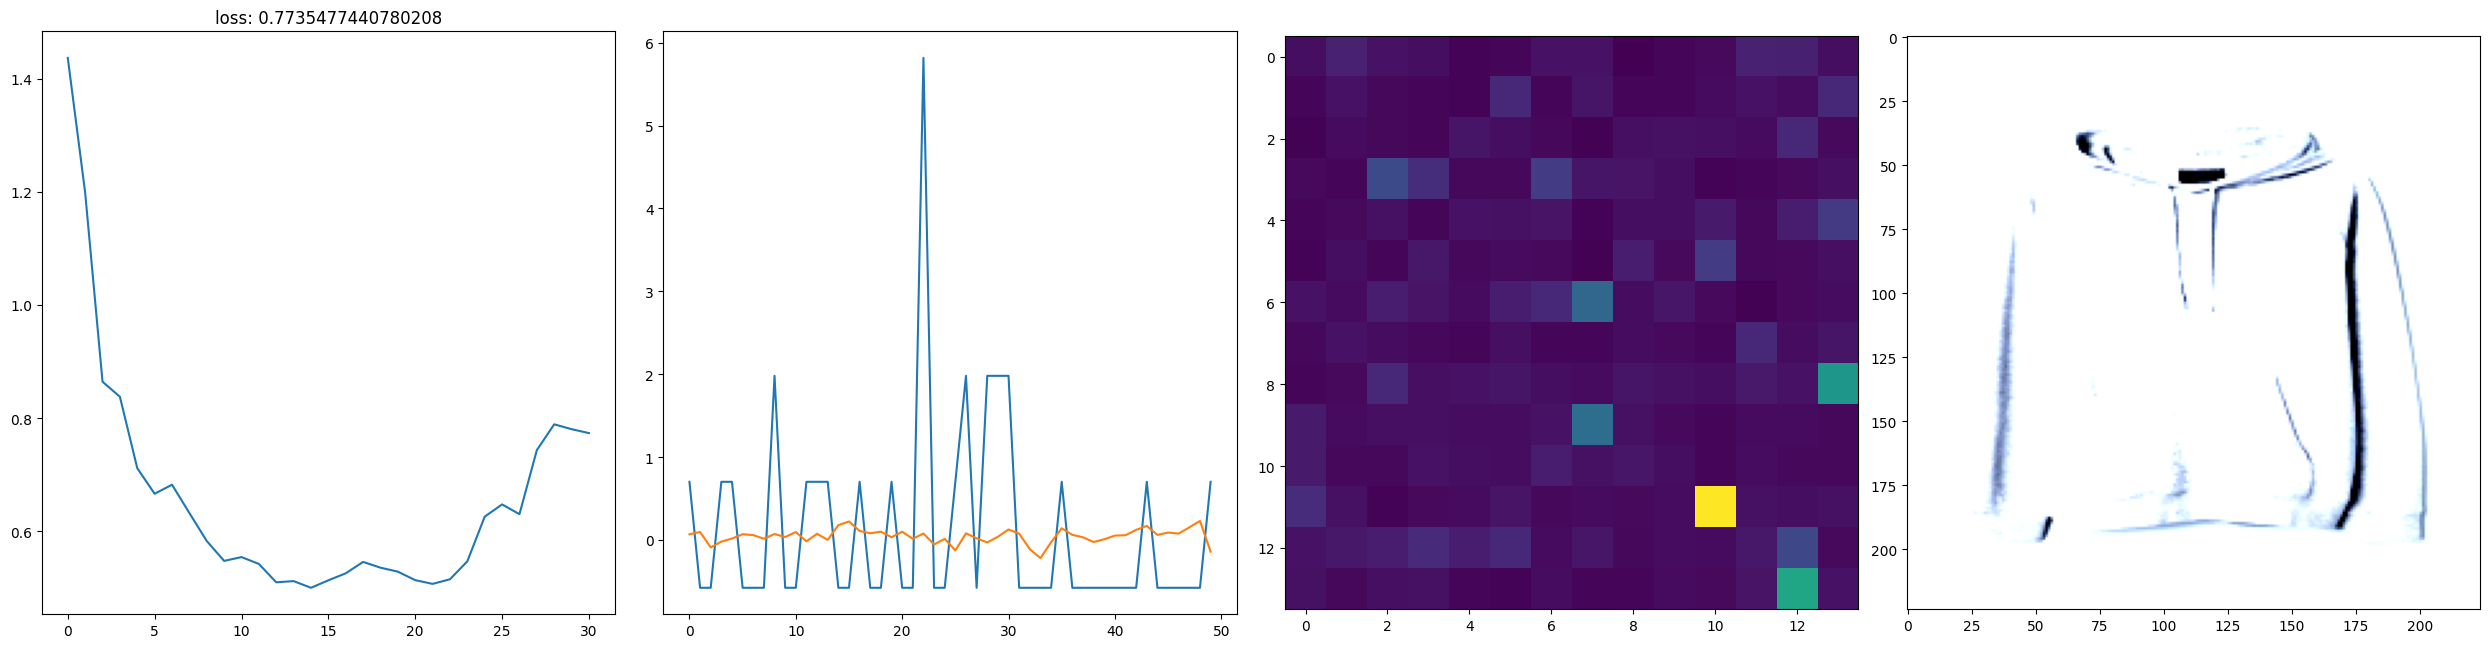

 33%|███▎      | 613/1830 [02:09<03:42,  5.46it/s]

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
epoch = 10
 
epoch_loss = {}
for e in range(epoch):
    loss = train_epoch(model, optimizer, train_dataloader, config, e)
    scheduler.step()
    epoch_loss[e] = loss

    # Save model
    if not is_test_mode:
        now = datetime.datetime.now()
        path = f"./saved_fine_tuning_epoch{e}_{now}"
        torch.save(model.state_dict(), path)

print(epoch_loss)